In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import time
import argparse

from tensorboardX import SummaryWriter

from dataloader import *
from utils import *
from model import *

if __name__ == '__main__':
    seed = 123
    np.random.seed(seed)
    torch.manual_seed(seed)

    parser = argparse.ArgumentParser(description='Add logP, TPSA, MR, PBF value on .smi files')
    # ===== Model Definition =====#
    parser.add_argument("-v", "--vocab_size", type=int, default=41)
    parser.add_argument("-i", "--in_dim", type=int, default=59)
    parser.add_argument("-o", "--out_dim", type=int, default=256)
    parser.add_argument("-m", "--molvec_dim", type=int, default=256)

    parser.add_argument("-n", "--n_layer", type=int, default=4)
    parser.add_argument("-k", "--n_attn_heads", type=int, default=8)
    parser.add_argument("-c", "--sc_type", type=str, default='sc')

    parser.add_argument("-a", "--use_attn", type=bool, default=True)
    parser.add_argument("-b", "--use_bn", type=bool, default=True)
    parser.add_argument("-e", "--emb_train", type=bool, default=True)
    parser.add_argument("-dp", "--dp_rate", type=float, default=0.1)
    parser.add_argument("--act", type=str, default='gelu')

    # ===== Optimizer =====#
    parser.add_argument("-u", "--optim", type=str, default='ADAM')
    parser.add_argument("-lf", "--lr_factor", type=float, default=2.0)
    parser.add_argument("-ls", "--lr_step", type=int, default=4000)

    # ===== Training =====#
    parser.add_argument("-p", "--train_logp", type=bool, default=True)
    parser.add_argument("-r", "--train_mr", type=bool, default=True)
    parser.add_argument("-t", "--train_tpsa", type=bool, default=True)
    parser.add_argument("-mr", "--masking_rate", type=float, default=0.15)
    parser.add_argument("-er", "--erase_rate", type=float, default=0.5)


    parser.add_argument("-ep", "--epoch", type=int, default=100)
    parser.add_argument("-bs", "--batch_size", type=int, default=3)
    parser.add_argument("-tbs", "--test_batch_size", type=int, default=3)
    parser.add_argument("-nw", "--num_workers", type=int, default=8)

    # ===== Logging =====#
    parser.add_argument("-li", "--log_every", type=int, default=10 * 10)  # Test: 10  #Default 40*10
    parser.add_argument("-vi", "--validate_every", type=int, default=100)  # Test:50 #Default 40*50
    parser.add_argument("-si", "--save_every", type=int, default=40 * 100)  # Test:50 #Default 40*100

    parser.add_argument("-mn", "--model_name", type=str, required=True)
    parser.add_argument("--log_path", type=str, default='runs')
    parser.add_argument("--ck_filename", type=str, default=None)  # 'model_ck_000_000000100.tar')
    parser.add_argument("--dataset_path", type=str, default='./dataset/data_xxs')

    args = parser.parse_args(["-mn", "masking_debug"])

    # ===== Experiment Setup =====#
    args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    args.model_explain = make_model_comment(args)
    train_writer = SummaryWriter(join(args.log_path, args.model_name + '_train'))
    val_writer = SummaryWriter(join(args.log_path, args.model_name + '_val'))
    train_writer.add_text(tag='model', text_string='{}:{}'.format(args.model_name, args.model_explain),
                          global_step=0)
    logger = get_logger(join(args.log_path, args.model_name + '_train'))

    # ===== Loading Dataset =====#
    train_dataset_path = args.dataset_path + '/train'
    val_dataset_path = args.dataset_path + '/val'
    list_trains = get_dir_files(train_dataset_path)
    list_vals = get_dir_files(val_dataset_path)


In [2]:
train_dataloader = zincDataLoader(join(train_dataset_path, list_trains[0]),
                                  batch_size=512,
                                  drop_last=False,
                                  shuffle_batch=False,
                                  num_workers=15,
                                  masking_rate=0.15,
                                  erase_rate=0.15)

In [3]:
from tqdm import tqdm
symbol = list()
degree = list()
h = list()
valence = list()
isarom = list()

symbol2 = list()
degree2 = list()
h2 = list()
valence2 = list()
isarom2 = list()

for i in range(1):
    for batch in tqdm(train_dataloader):
        X = batch[0]
        X = X.reshape(-1, 5)
        symbol += (X[:,0].tolist())
        degree += (X[:,1].tolist())
        h += (X[:,2].tolist())
        valence += (X[:,3].tolist())
        isarom += (X[:,4].tolist())
        
        X = batch[4]
        X = X.reshape(-1, 5)
        symbol2 += (X[:,0].tolist())
        degree2 += (X[:,1].tolist())
        h2 += (X[:,2].tolist())
        valence2 += (X[:,3].tolist())
        isarom2 += (X[:,4].tolist())
        

100%|██████████| 194/194 [00:10<00:00, 18.24it/s]


In [4]:
df = pd.DataFrame.from_dict({
    'symbol': symbol,
    'degree': degree,
    'h': h,
    'valence': valence,
    'isarom': isarom
})

df2 = pd.DataFrame.from_dict({
    'symbol': symbol2,
    'degree': degree2,
    'h': h2,
    'valence': valence2,
    'isarom': isarom2
})


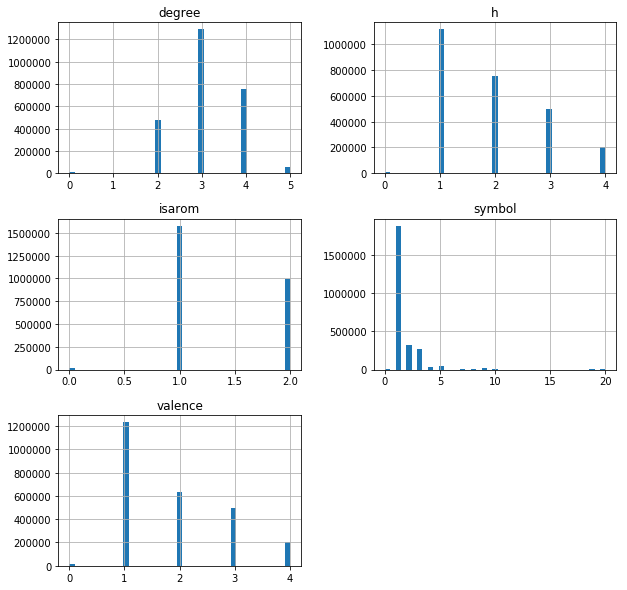

In [5]:
%matplotlib inline
hist = df.hist(bins=41, figsize=(10, 10))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2718650b8>,
      dtype=object)

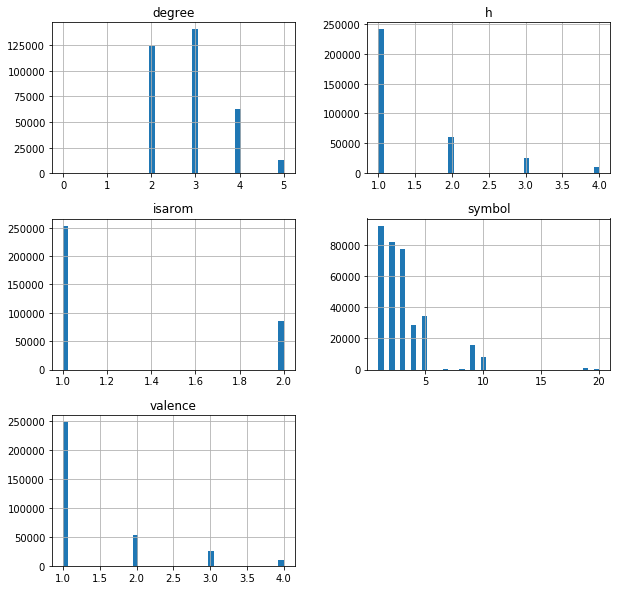

In [6]:
%matplotlib inline

df2.hist(bins=41, figsize=(10, 10))


In [7]:
sy = df['symbol'].value_counts()#sort=False)
print(sy)

sy2 = df2['symbol'].value_counts()#sort=False)
print(sy2)

1     1882362
2      314667
3      263429
5       51730
4       33957
9       17370
0       12074
10       8007
19        676
7          29
8          23
20          8
Name: symbol, dtype: int64
1     92177
2     81724
3     77449
5     34185
4     28262
9     16013
10     7833
19      676
7        29
8        23
20        8
Name: symbol, dtype: int64
